# <center>A Quantum Actor Critic Agent</center>

In [1]:
import time, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
from keras import Input, layers, Model
import numpy as np
import gym

import matplotlib.pyplot as plt
from cirq.contrib.svg import circuit_to_svg
from IPython.display import HTML, SVG
from pyvirtualdisplay import Display

In [2]:
from utilities import train_agent, render, animation
from custom_layers import Scale, Circuit
from rl_algorithms import Reinforce

<center>Create Gym Environment</center>

In [3]:
env = gym.make("CartPole-v1")

<center>Define Model Architecture</center>

In [4]:
num_layers = 5

inputs = Input(shape=env.observation_space.shape[0], dtype=tf.dtypes.float32, name='Input')
circuit = Circuit(num_layers)(inputs)
scaling = Scale()(circuit)

policy_logits = layers.Lambda(lambda x: tf.stack([x[:, 0] * x[:, 2], x[:, 1] * x[:, 3]], axis=1), name="Logits")(scaling)
policy_probabilities = layers.Softmax(name="Probabilities")(policy_logits)
policy = Model(inputs=[inputs], outputs=[policy_probabilities], name="Policy")

policy.summary()

Model: "Policy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 4)]               0         
                                                                 
 PQC (Circuit)               (None, 4)                 80        
                                                                 
 Scaling (Scale)             (None, 4)                 4         
                                                                 
 Logits (Lambda)             (None, 2)                 0         
                                                                 
 Probabilities (Softmax)     (None, 2)                 0         
                                                                 
Total params: 84 (336.00 Byte)
Trainable params: 84 (336.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


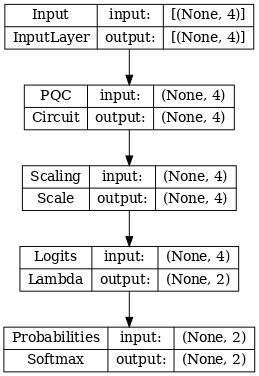

In [5]:
tf.keras.utils.plot_model(policy, to_file="/tmp/model.png", show_shapes=True, dpi=70)

In [6]:
%%capture
circuit = circuit_to_svg(policy.get_layer("PQC").circuit)

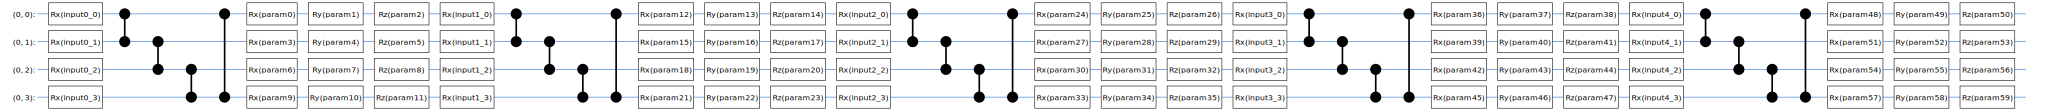

In [7]:
SVG(circuit)

<center>Train Model</center>

In [8]:
%%time

agent = Reinforce(policy, learning_rate=0.01, discount_factor=0.99)

def shaped_reward(reward, observation):
    position, pos_vel, angle, angle_vel = observation
    #return (1 - tf.abs(angle))
    return tf.exp(-tf.abs(angle))

state_bounds = np.array([2.4, 2.5, 0.21, 2.5]).astype(np.float32)
    
agent, total_rewards, episode_lengths = train_agent(env, agent, shaped_reward,
                                                    500, 5000, state_bounds,
                                                    (475, 100), True)

Episode: 324, Steps: 402, Average Episode Length: 474.3
Solved at Episode 325, Average Episode Length: 477.3

CPU times: user 8min 50s, sys: 1min 52s, total: 10min 43s
Wall time: 6min 38s


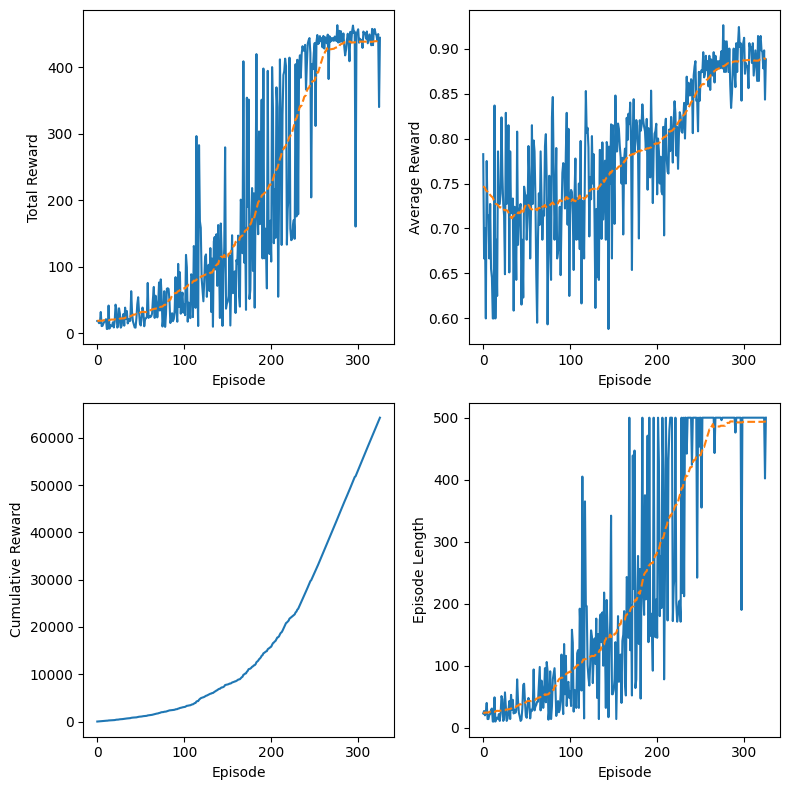

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

def smooth(s, alpha=0.2):
    averaging_length = int(len(s)*alpha)
    s = np.pad(s, (averaging_length//2, averaging_length//2), mode='edge')
    return np.convolve(s, np.ones(averaging_length)/averaging_length, mode='valid')

labels = ['Total Reward', 'Average Reward', 'Cumulative Reward', 'Episode Length']
data = [total_rewards, np.array(total_rewards) / episode_lengths, np.cumsum(total_rewards), episode_lengths]

for ax, label, data in zip(axes.flat, labels, data):
    ax.set_xlabel('Episode')
    ax.set_ylabel(label)
    ax.plot(data)
    if label != 'Cumulative Reward': ax.plot(smooth(data), '--')

fig.tight_layout()
plt.show()

In [10]:
vdisp = Display(visible=0, size=(500, 500)).start()

def action_fn(env, observation):
    observation = observation / state_bounds
    return agent.act(observation).numpy()

env = gym.make('CartPole-v1')
frames = render(env, action_fn, 500)
env.close()

HTML(animation(frames, len(frames)/24e-3).to_html5_video())

In [11]:
timestamp = time.strftime("%Y.%m.%d-%H.%M")
dirname = f'./QPG{timestamp}'
os.mkdir(dirname)
print(timestamp)

results = {"Total Reward":total_rewards, "Episode Length": episode_lengths}
np.save(f'{dirname}/results.npy', results)
agent.policy.save(f'{dirname}/policy.keras')

2024.08.04-10.04
